In [1]:
from pymongo import MongoClient
import json5 as json
from collections import defaultdict
import pandas as pd
import numpy as np
from statistics import mean, median
import os
from time import time

pd.set_option('display.max_colwidth', None) 

In [2]:
client = MongoClient()
db = client['JiraRepos']

## Первичный анализ

### Загрузка справочных данных

In [65]:
with open(r'ThePublicJiraDataset\0. DataDefinition\jira_data_sources.json') as f:
    jira_data_sources = json.load(f)

with open(r'ThePublicJiraDataset\0. DataDefinition\jira_issuetype_information.json') as f:
    jira_issuetype_information = json.load(f)

with open(r'ThePublicJiraDataset\0. DataDefinition\jira_issuelinktype_information.json') as f:
    jira_issuelinktype_information = json.load(f)


In [66]:
ALL_JIRAS = [jira_name for jira_name in jira_data_sources.keys()]
ALL_JIRAS

['Apache',
 'Hyperledger',
 'IntelDAOS',
 'JFrog',
 'Jira',
 'JiraEcosystem',
 'MariaDB',
 'Mindville',
 'Mojang',
 'MongoDB',
 'Qt',
 'RedHat',
 'Sakai',
 'SecondLife',
 'Sonatype',
 'Spring']

In [67]:
df_jiras = pd.DataFrame(
    np.nan,
    columns=['Born',
             'Total issues', 'Documented i_types', 'Used i_types',
             'Total links', 'Documented l_types', 'Used l_types',
             'Total changes', 'Changes per Issue',
             'Unique Projects',
             'Total Comments', 'Comments per Issue'],
    index=ALL_JIRAS + ['Sum', 'Median', 'Std Dev']
)

### Формирование сводной таблицы на данных из локальной MongoDB

In [68]:
def num_of_issues(jira_name):
    num_issues = db[jira_name].count_documents({})
    return num_issues

def num_of_documented_itypes(jira_name):
    return len(jira_issuetype_information[jira_name])

def num_of_used_itypes(jira_name):
    query_result = list(db[jira_name].aggregate([
        { '$project': { '_id': 0, 'issuetype_name': '$fields.issuetype.name' } },
        { '$group': { '_id': None, 'issuetype_names': { '$addToSet': '$issuetype_name' } } }
        ]))
    unique_fin = set(query_result[0]['issuetype_names']) if query_result else set()
    query_result = list(db[jira_name].aggregate([
            { '$unwind': '$changelog.histories' },
            { '$unwind': '$changelog.histories.items' },
            { '$match': { 'changelog.histories.items.field': 'issuetype' } },
            { '$project': { '_id': 0, 'issuetype_name': '$changelog.histories.items.fromString' } },
            { '$group': { '_id': None, 'issuetype_names': { '$addToSet': '$issuetype_name' } } }
        ]))

    unique_hist = set(query_result[0]['issuetype_names']) if query_result else 0
    return len(set.union(unique_fin, unique_hist))

def num_of_links(jira_name):
    issuelinks_result = list(db[jira_name].aggregate([
            { '$match': { 'fields.issuelinks': { '$exists': True, '$ne': [] } } },
            { '$project': { '_id': 0, 'issuelink_ids_issue': '$fields.issuelinks.id' } },
            { '$unwind': '$issuelink_ids_issue' },
            { '$group': { '_id': None, 'issuelink_unique_ids': { '$addToSet': '$issuelink_ids_issue' } } }
        ]))
    num_issuelinks = len(set(issuelinks_result[0]['issuelink_unique_ids'])) if issuelinks_result else 0
    subtasks_result = list(db[jira_name].aggregate([
            { '$match': { 'fields.subtasks': { '$exists': True, '$ne': [] } } },
            { '$project': { '_id': 0, 'num_issue_subtasks': { '$size': '$fields.subtasks' } } },
            { '$group': { '_id': None, 'num_subtasks': { '$sum': '$num_issue_subtasks' } } }
        ]))
    num_subtasks = subtasks_result[0]['num_subtasks'] if subtasks_result else 0
    epiclinkfield_dict = {
            'Apache': 'customfield_12311120',
            'Hyperledger': 'customfield_10006',
            'IntelDAOS': 'customfield_10092',
            'JFrog': 'customfield_10806',
            'Jira': 'customfield_12931',
            'JiraEcosystem': 'customfield_12180',
            'MariaDB': 'customfield_10600',
            'Mindville': 'customfield_10000',
            'Mojang': 'customfield_11602',
            'MongoDB': 'customfield_10857',
            'Qt': 'customfield_10400',
            'RedHat': 'customfield_12311140',
            'Sakai': 'customfield_10772',
            'SecondLife': 'customfield_10871',
            'Sonatype': 'customfield_11500',
            'Spring': 'customfield_10680'
        }
    epiclinks_result = list(db[jira_name].aggregate([
            { '$project': { 'epiclink_field': f"$fields.{epiclinkfield_dict[jira_name]}" } },
            { '$match': { 'epiclink_field': { '$exists': True, '$ne': None } } },
            { '$count': 'num_epiclinks' }
        ]))
    num_epiclinks = epiclinks_result[0]['num_epiclinks'] if epiclinks_result else 0
    return sum([num_issuelinks, num_subtasks, num_epiclinks])

def num_of_documented_ltypes(jira_name):
    return len(jira_issuelinktype_information[jira_name]) if jira_name in jira_issuelinktype_information else 0

def num_of_used_ltypes(jira_name):
    query_result = list(db[jira_name].aggregate([
            { '$unwind': '$fields.issuelinks' },
            { '$project': { '_id': 0, 'issuelinktype_name': '$fields.issuelinks.type.name' } },
            { '$group': { '_id': None, 'issuelinktype_names': { '$addToSet': '$issuelinktype_name' } } }
        ]))
    return len(set(query_result[0]['issuelinktype_names'])) if query_result else 0

def extract_born(jira_name):
    created_dates = [issue['fields']['created'] for issue in db[jira_name].aggregate([
                { '$project': { '_id': 0, 'fields.created': 1 } },
                { '$sort': { 'fields.created': 1 } },
                { '$limit': 500 }
            ])
        ]
    if jira_name == 'Apache':
        created_dates = created_dates[289:]
    elif jira_name == 'Jira':
        created_dates = created_dates[1:]
    elif jira_name == 'IntelDAOS':
        created_dates = created_dates[1:]
    elif jira_name == 'Qt':
        created_dates = created_dates[7:]
    return created_dates[0][:4]

def num_of_changes(jira_name):
    query_result = list(db[jira_name].aggregate([
            { '$project': { '_id': 0, 'changelog.histories.items.field': 1 } },
            { '$unwind': '$changelog.histories' },
            { '$unwind': '$changelog.histories.items' },
            { '$count': 'num_changes' }
        ]))
    return query_result[0]['num_changes'] if query_result else 0

def num_of_projects(jira_name):
    query_result = list(db[jira_name].aggregate([
            { '$project': { '_id': 0, 'project_name': '$fields.project.name' } },
            { '$group': { '_id': None, 'project_names': { '$addToSet': '$project_name' } } }
        ]))
    unique_projects_final = set(query_result[0]['project_names']) if query_result else set()
    query_result = list(db[jira_name].aggregate([
            { '$unwind': '$changelog.histories' },
            { '$unwind': '$changelog.histories.items' },
            { '$match': { 'changelog.histories.items.field': 'project' } },
            { '$project': { '_id': 0, 'project_name': '$changelog.histories.items.fromString' } },
            { '$group': { '_id': None, 'project_names': { '$addToSet': '$project_name' } } }
        ]))
    unique_projects_history = set(query_result[0]['project_names']) if query_result else set()
    return len(set.union(unique_projects_final, unique_projects_history))

def num_of_comments(jira_name):
    query_result = list(db[jira_name].aggregate([
            { '$match': { 'fields.comments': { '$ne': None } } },
            { '$project': { '_id': 0, 'num_comments_per_issue': { '$size': '$fields.comments' } } },
            { '$group': { '_id': None, 'num_comments': { '$sum': '$num_comments_per_issue' } } },
        ]))
    return query_result[0]['num_comments'] if query_result else 0

In [69]:
for jira_name in ALL_JIRAS:
    print(f"\tОбработка репозитория: {jira_name} ...")

    df_jiras.loc[jira_name, 'Total issues'] = num_of_issues(jira_name)
    df_jiras.loc[jira_name, 'Documented i_types'] = num_of_documented_itypes(jira_name)
    df_jiras.loc[jira_name, 'Used i_types'] = num_of_used_itypes(jira_name)


    df_jiras.loc[jira_name, 'Total links'] = num_of_links(jira_name)
    df_jiras.loc[jira_name, 'Documented l_types'] = num_of_documented_ltypes(jira_name)
    df_jiras.loc[jira_name, 'Used l_types'] = num_of_used_ltypes(jira_name)

    df_jiras.loc[jira_name, 'Born'] = extract_born(jira_name)
    df_jiras.loc[jira_name, 'Total changes'] = num_of_changes(jira_name)
    df_jiras.loc[jira_name, 'Changes per Issue'] = round(df_jiras.loc[jira_name, 'Total changes'] / df_jiras.loc[jira_name, 'Total issues'])
    df_jiras.loc[jira_name, 'Unique Projects'] = num_of_projects(jira_name)
    df_jiras.loc[jira_name, 'Total Comments'] = num_of_comments(jira_name)
    df_jiras.loc[jira_name, 'Comments per Issue'] = round(df_jiras.loc[jira_name, 'Total Comments'] / df_jiras.loc[jira_name, 'Total issues'])


print('Выполнено')

	Обработка репозитория: Apache ...


C:\Users\feoma\AppData\Local\Temp\ipykernel_45208\3260586066.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2000' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_jiras.loc[jira_name, 'Born'] = extract_born(jira_name)


	Обработка репозитория: Hyperledger ...
	Обработка репозитория: IntelDAOS ...
	Обработка репозитория: JFrog ...
	Обработка репозитория: Jira ...
	Обработка репозитория: JiraEcosystem ...
	Обработка репозитория: MariaDB ...
	Обработка репозитория: Mindville ...
	Обработка репозитория: Mojang ...
	Обработка репозитория: MongoDB ...
	Обработка репозитория: Qt ...
	Обработка репозитория: RedHat ...
	Обработка репозитория: Sakai ...
	Обработка репозитория: SecondLife ...
	Обработка репозитория: Sonatype ...
	Обработка репозитория: Spring ...
Выполнено


In [70]:
for header in df_jiras.columns:
    if header in ['Born']:
        continue
    df_jiras.loc['Sum', header] = sum(df_jiras[header][:len(ALL_JIRAS)])
    df_jiras.loc['Median', header] = median(df_jiras[header][:len(ALL_JIRAS)])
    df_jiras.loc['Std Dev', header] = np.std(df_jiras[header][:len(ALL_JIRAS)])
    
sep = {col_name: '{:,.0f}' for col_name in ['Total issues', 'Total links', 'Total changes', 'Total comments']}

display(df_jiras
        .style
        .set_table_styles([ dict(selector='th', props=[('text-align', 'left')] ) ])
        .format(sep,
            precision=0))

,Born,Total issues,Documented i_types,Used i_types,Total links,Documented l_types,Used l_types,Total changes,Changes per Issue,Unique Projects,Total Comments,Comments per Issue
Apache,2000,"1,014,926",48,49,"264,108",20,20,"10,625,810",10,657,4608221,5
Hyperledger,2016,"28,146",9,9,"16,846",6,6,"329,414",12,36,44590,2
IntelDAOS,2016,"9,474",4,11,"2,667",12,12,"142,052",15,7,32203,3
JFrog,2006,"15,535",30,22,"3,303",17,10,"139,614",9,35,13152,1
Jira,2002,"274,545",52,38,"110,507",19,18,"5,693,081",21,123,779104,3
JiraEcosystem,2004,"41,866",122,40,"12,439",19,18,"639,059",15,153,68387,2
MariaDB,2009,"31,229",11,10,"14,950",6,6,"379,014",12,24,0,0
Mindville,2015,"2,134",2,2,46,0,4,"5,475",3,10,0,0
Mojang,2012,"420,819",1,3,"215,821",6,5,"3,316,767",8,16,933348,2
MongoDB,2009,"137,172",31,37,"92,368",15,13,"2,376,753",17,95,368976,3


In [71]:
# сохраним в csv

df_jiras_f = df_jiras.reset_index().copy() 
df_jiras_f = df_jiras_f.round(0)
for col in df_jiras_f.select_dtypes(include=['int64', 'float64']).columns:
    df_jiras_f[col] = df_jiras_f[col].apply(lambda x: f"{x:,.0f}")

df_jiras_f.to_csv('pivot_1.csv', index=False, sep=';') 

### Визуализация результатов overview

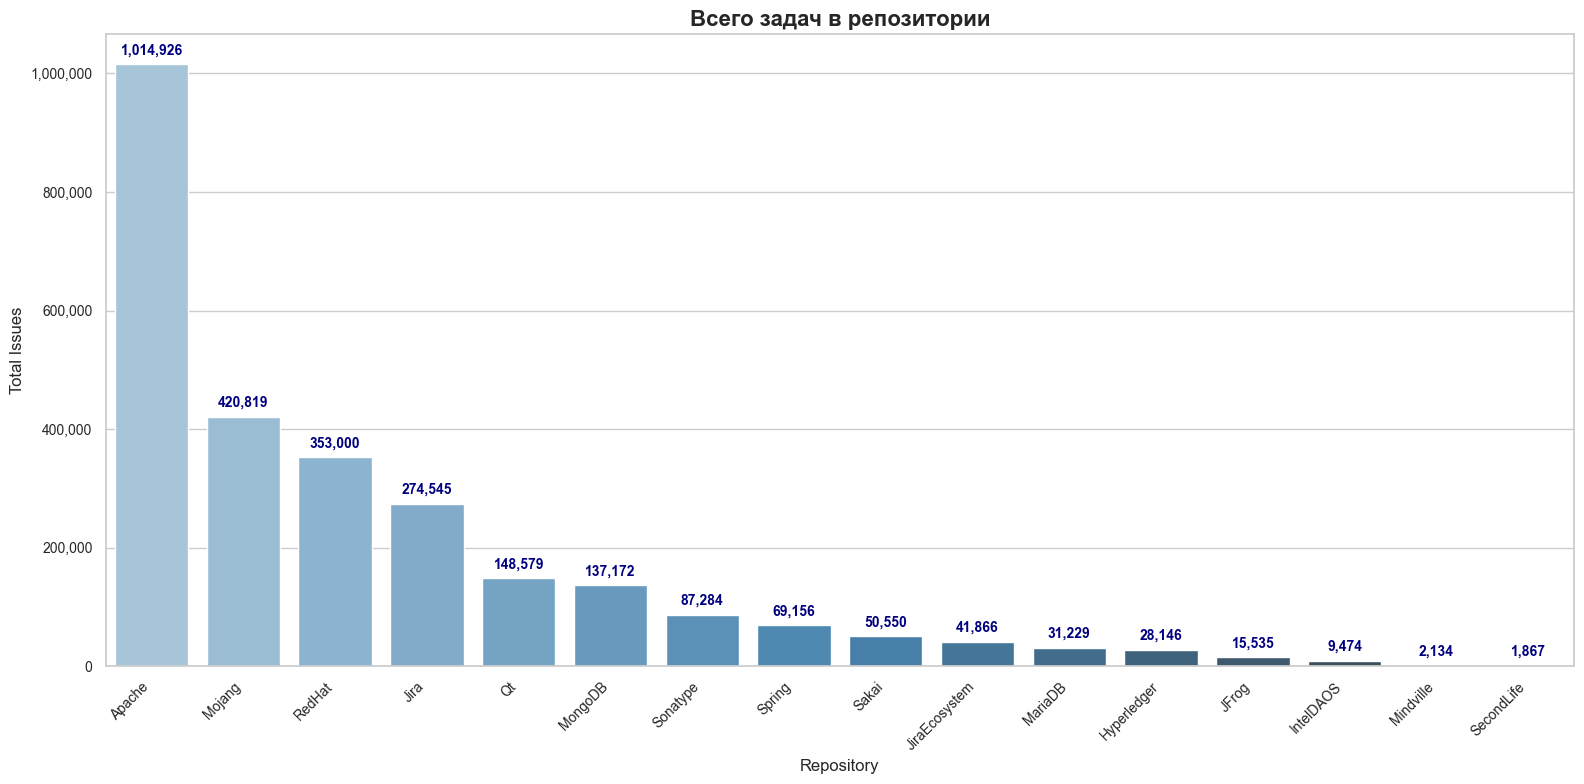

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

df_sorted = df_jiras[:16].sort_values(by='Total issues', ascending=False)

plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")

ax = sns.barplot(x=df_sorted.index, y=df_sorted['Total issues'], palette="Blues_d", hue=df_sorted.index, dodge=False, legend=False)
ax.set_title("Всего задач в репозитории", fontsize=16, weight='bold')
ax.set_xlabel("Repository", fontsize=12)
ax.set_ylabel("Total Issues", fontsize=12)

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

for i in ax.containers:
    ax.bar_label(i, fmt='{:,.0f}', padding=5, fontsize=10, weight='bold', color='navy')

plt.tight_layout()
plt.show()

In [83]:
df_jiras_f = pd.read_csv('pivot_1.csv', sep=';') 

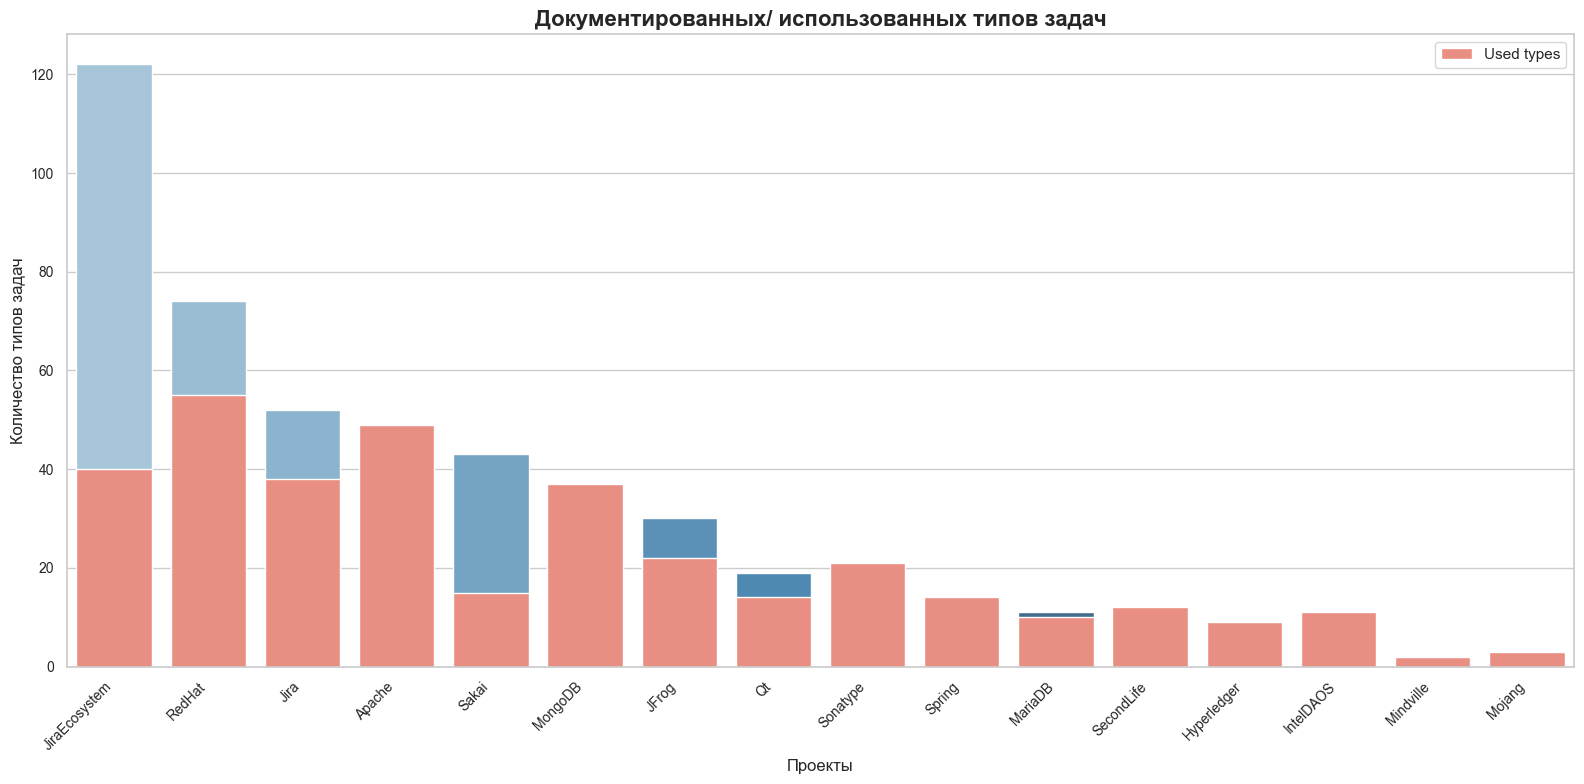

In [42]:
sns.set(style="whitegrid")
df_sorted = df_jiras_f[:16].sort_values(by='Documented i_types', ascending=False)
plt.figure(figsize=(16, 8))

ax = sns.barplot(
    x='index', 
    y='Documented i_types', 
    data=df_sorted, 
    palette="Blues_d",
    hue='index',
    legend=False,
    dodge=False)

sns.barplot(
    x='index', 
    y='Used i_types', 
    data=df_sorted, 
    color='salmon', 
    label='Used types', 
    dodge=False)

ax.set_title("Документированных/ использованных типов задач", fontsize=16, weight='bold')
ax.set_xlabel("Проекты", fontsize=12)
ax.set_ylabel("Количество типов задач", fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.legend()
plt.tight_layout()
plt.show()
